# GP pour pricer un straddle

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from scipy.stats import norm
import math

import seaborn as sns
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (9, 5)

np.random.seed(42)

In [20]:
# =========================
# 1) Paramètres fixes & BS
# =========================
r     = 0.01  # Taux risk-free
sigma = 0.2   # Volatilité
K     = 100.0 # Strike
T     = 1.0   # Maturité (en années)

def bs_call_price(S):
    """Prix BS call (Européen) en 1D avec param. fixes."""
    if T <= 1e-12:
        return max(S - K, 0.0)
    d1 = (np.log(S / K) + (r + 0.5*sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S * norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

def bs_put_price(S):
    """Prix BS put (Européen) en 1D avec param. fixes."""
    if T <= 1e-12:
        return max(K - S, 0.0)
    d1 = (np.log(S / K) + (r + 0.5*sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    # put-call parity => put = call + K e^{-rT} - S
    call_val = bs_call_price(S)
    put_val = call_val + K*np.exp(-r*T) - S
    return put_val

print(f"Exemple: Call( S=100 ) = {bs_call_price(100):.4f}")
print(f"         Put(  S=100 ) = {bs_put_price(100):.4f}")


Exemple: Call( S=100 ) = 8.4333
         Put(  S=100 ) = 7.4383


In [21]:
# ==================================
# 2) Génération de différents maillages
# ==================================
# On va comparer 3 stratégies pour "X_train" (S):
#   1) Grille uniforme
#   2) Grille random
#   3) Grille dense autour du strike (K=100)

def gen_grid_uniform(n_points=3, s_min=50, s_max=150):
    S_vals = np.linspace(s_min, s_max, n_points)
    return S_vals

def gen_grid_random(n_points=3, s_min=50, s_max=150):
    S_vals = np.random.uniform(s_min, s_max, n_points)
    S_vals.sort()  
    return S_vals

def gen_grid_dense_near_strike(n_points=3, s_min=50, s_max=150, center=100):
    """
    Ex: on place 100% des points dans [K-20, K+20],
    """
    n_dense = n_points

    dense_min, dense_max = center-20, center+20
    S_dense = np.linspace(dense_min, dense_max, n_dense)
    return S_dense

def create_training_dataset(S_array, which="call"):
    """Retourne X_train(2D), y_train(1D) en fonction de S_array."""
    X_train = S_array.reshape(-1,1)
    if which == "call":
        y_train = np.array([bs_call_price(s) for s in S_array])
    elif which == "put":
        y_train = np.array([bs_put_price(s) for s in S_array])
    else:
        raise ValueError("value error for which: call / put")
    return X_train, y_train

S_test = np.linspace(50,150,300)
X_test = S_test.reshape(-1,1)

y_test_call = np.array([bs_call_price(s) for s in S_test])
y_test_put  = np.array([bs_put_price(s)  for s in S_test])

In [22]:
# =============== Comparer uniform/random/dense avec très peu de points ===============

def train_and_evaluate_gp(S_train, y_train, X_test, y_test):

    kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-5, 1e3))
    
    # Construction du GP : 
    gp = GaussianProcessRegressor(
        kernel=kernel, 
        alpha=1e-8,
        n_restarts_optimizer=20,
        random_state=42
    )
    
    gp.fit(S_train.reshape(-1,1), y_train)
    y_pred = gp.predict(X_test)
    mse = np.mean((y_pred - y_test)**2)
    
    return gp, mse, y_pred


n_pts = 5

S_unif  = gen_grid_uniform(n_pts)
S_rand  = gen_grid_random(n_pts)
S_dense = gen_grid_dense_near_strike(n_pts)

# Pour le call
Xu, yu = create_training_dataset(S_unif,  which="call")
Xr, yr = create_training_dataset(S_rand,  which="call")
Xd, yd = create_training_dataset(S_dense, which="call")

# ==== Impression des points choisis =====
print("=== TRAINING POINTS - Uniform ===")
for i, s in enumerate(S_unif):
    print(f" i={i}, S={s:.2f}, Price={yu[i]:.4f}")

print("\n=== TRAINING POINTS - Random ===")
for i, s in enumerate(S_rand):
    print(f" i={i}, S={s:.2f}, Price={yr[i]:.4f}")

print("\n=== TRAINING POINTS - Dense near strike ===")
for i, s in enumerate(S_dense):
    print(f" i={i}, S={s:.2f}, Price={yd[i]:.4f}")
print("")

# ==== Entraînement & évaluation MSE =====
gp_u, mse_u, ypred_u = train_and_evaluate_gp(Xu[:,0], yu, X_test, y_test_call)
gp_r, mse_r, ypred_r = train_and_evaluate_gp(Xr[:,0], yr, X_test, y_test_call)
gp_d, mse_d, ypred_d = train_and_evaluate_gp(Xd[:,0], yd, X_test, y_test_call)

print(f"CALL - Comparaison MSE (n_pts={n_pts}):")
print(f"  Uniform grid MSE = {mse_u:.6f}")
print(f"  Random  grid MSE = {mse_r:.6f}")
print(f"  Dense   grid MSE = {mse_d:.6f}")

=== TRAINING POINTS - Uniform ===
 i=0, S=50.00, Price=0.0011
 i=1, S=75.00, Price=0.6460
 i=2, S=100.00, Price=8.4333
 i=3, S=125.00, Price=27.3291
 i=4, S=150.00, Price=51.1622

=== TRAINING POINTS - Random ===
 i=0, S=65.60, Price=0.1166
 i=1, S=87.45, Price=3.0285
 i=2, S=109.87, Price=14.8463
 i=3, S=123.20, Price=25.7257
 i=4, S=145.07, Price=46.3234

=== TRAINING POINTS - Dense near strike ===
 i=0, S=80.00, Price=1.3022
 i=1, S=90.00, Price=3.8614
 i=2, S=100.00, Price=8.4333
 i=3, S=110.00, Price=14.9447
 i=4, S=120.00, Price=22.9419

CALL - Comparaison MSE (n_pts=5):
  Uniform grid MSE = 2.939073
  Random  grid MSE = 1.928081
  Dense   grid MSE = 299.477212


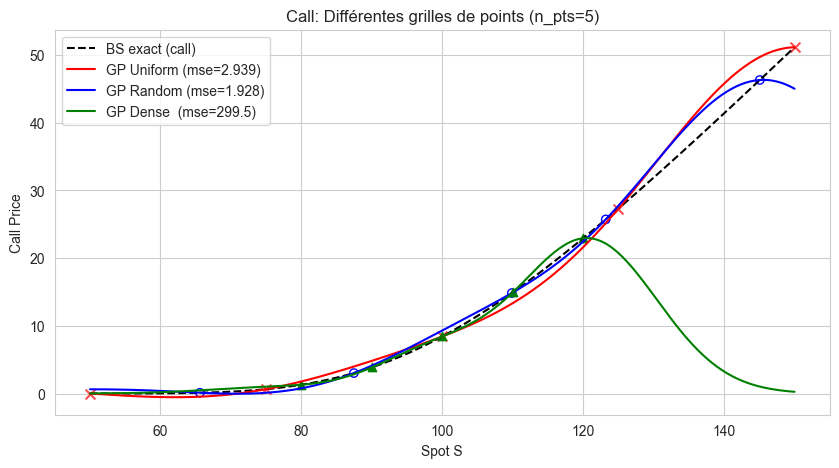

In [23]:
# Plot comparatif pour le call
plt.figure(figsize=(10,5))

plt.plot(S_test, y_test_call, 'k--', label="BS exact (call)")

# Traces
plt.plot(S_test, ypred_u, 'r-',  label=f"GP Uniform (mse={mse_u:.4g})")
plt.plot(S_test, ypred_r, 'b-',  label=f"GP Random (mse={mse_r:.4g})")
plt.plot(S_test, ypred_d, 'g-',  label=f"GP Dense  (mse={mse_d:.4g})")

# Points
plt.scatter(S_unif, [bs_call_price(s) for s in S_unif], marker='x', c='r', s=50, alpha=0.7)
plt.scatter(S_rand, [bs_call_price(s) for s in S_rand], marker='o', facecolors='none', edgecolors='b')
plt.scatter(S_dense,[bs_call_price(s) for s in S_dense],marker='^', c='g')

plt.title(f"Call: Différentes grilles de points (n_pts={n_pts})")
plt.xlabel("Spot S")
plt.ylabel("Call Price")
plt.legend()
plt.show()


In [24]:
# ========================================
# 4) Faire la même chose pour le PUT
# ========================================
S_unif_p  = gen_grid_uniform(n_pts)
S_rand_p  = gen_grid_random(n_pts)
S_dense_p = gen_grid_dense_near_strike(n_pts)

Xu_p, yu_p = create_training_dataset(S_unif_p, "put")
Xr_p, yr_p = create_training_dataset(S_rand_p, "put")
Xd_p, yd_p = create_training_dataset(S_dense_p,"put")

# ==== Impression des points choisis =====
print("=== TRAINING POINTS - Uniform ===")
for i, s in enumerate(S_unif_p):
    print(f" i={i}, S={s:.2f}, Price={yu[i]:.4f}")

print("\n=== TRAINING POINTS - Random ===")
for i, s in enumerate(S_rand_p):
    print(f" i={i}, S={s:.2f}, Price={yr[i]:.4f}")

print("\n=== TRAINING POINTS - Dense near strike ===")
for i, s in enumerate(S_dense_p):
    print(f" i={i}, S={s:.2f}, Price={yd[i]:.4f}")
print("")

# ==== Entraînement & évaluation MSE =====
gp_u_p, mse_u_p, ypred_u_p = train_and_evaluate_gp(Xu_p[:,0], yu_p, X_test, y_test_put)
gp_r_p, mse_r_p, ypred_r_p = train_and_evaluate_gp(Xr_p[:,0], yr_p, X_test, y_test_put)
gp_d_p, mse_d_p, ypred_d_p = train_and_evaluate_gp(Xd_p[:,0], yd_p, X_test, y_test_put)

print("CALL - Comparaison MSE (n_pts={n_pts}):")
print(f"  Uniform grid MSE = {mse_u_p:.6f}")
print(f"  Random  grid MSE = {mse_r_p:.6f}")
print(f"  Dense   grid MSE = {mse_d_p:.6f}")

=== TRAINING POINTS - Uniform ===
 i=0, S=50.00, Price=0.0011
 i=1, S=75.00, Price=0.6460
 i=2, S=100.00, Price=8.4333
 i=3, S=125.00, Price=27.3291
 i=4, S=150.00, Price=51.1622

=== TRAINING POINTS - Random ===
 i=0, S=55.81, Price=0.1166
 i=1, S=65.60, Price=3.0285
 i=2, S=110.11, Price=14.8463
 i=3, S=120.81, Price=25.7257
 i=4, S=136.62, Price=46.3234

=== TRAINING POINTS - Dense near strike ===
 i=0, S=80.00, Price=1.3022
 i=1, S=90.00, Price=3.8614
 i=2, S=100.00, Price=8.4333
 i=3, S=110.00, Price=14.9447
 i=4, S=120.00, Price=22.9419

CALL - Comparaison MSE (n_pts={n_pts}):
  Uniform grid MSE = 2.803133
  Random  grid MSE = 24.547616
  Dense   grid MSE = 274.628800


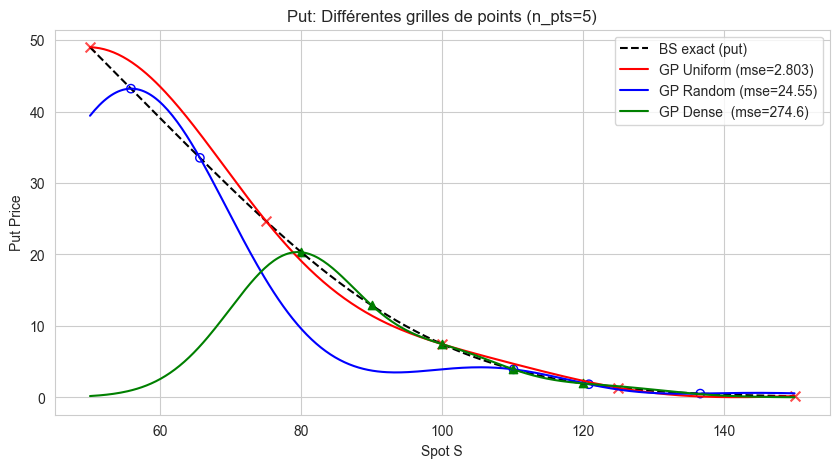

In [25]:
# Visu du PUT
plt.figure(figsize=(10,5))

plt.plot(S_test, y_test_put, 'k--', label="BS exact (put)")

plt.plot(S_test, ypred_u_p, 'r-', label=f"GP Uniform (mse={mse_u_p:.4g})")
plt.plot(S_test, ypred_r_p, 'b-', label=f"GP Random (mse={mse_r_p:.4g})")
plt.plot(S_test, ypred_d_p, 'g-', label=f"GP Dense  (mse={mse_d_p:.4g})")

# Points
plt.scatter(S_unif_p, [bs_put_price(s) for s in S_unif_p], marker='x', c='r', s=50, alpha=0.7)
plt.scatter(S_rand_p, [bs_put_price(s) for s in S_rand_p], marker='o', facecolors='none', edgecolors='b')
plt.scatter(S_dense_p,[bs_put_price(s) for s in S_dense_p],marker='^', c='g')

plt.title(f"Put: Différentes grilles de points (n_pts={n_pts})")
plt.xlabel("Spot S")
plt.ylabel("Put Price")
plt.legend()
plt.show()


=== Straddle MSE (CALL + PUT) ===
Uniform grid   => MSE=3.950131
Random  grid   => MSE=26.373182
Dense   grid   => MSE=572.676734


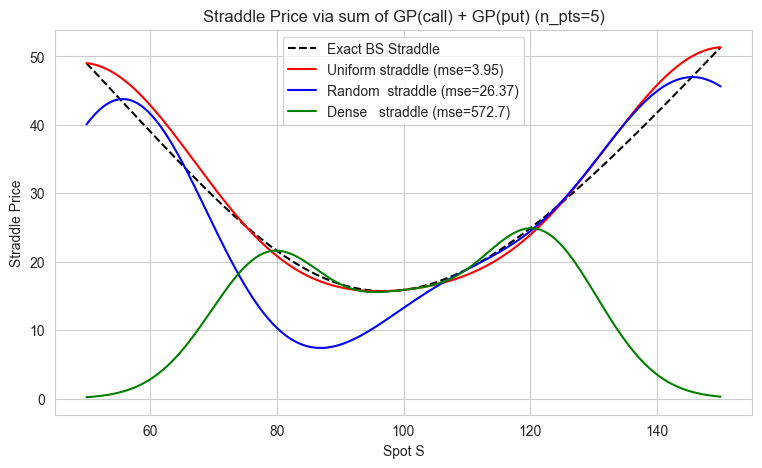

In [26]:
# ========================================
# 5) On peut aller plus loin pour modéliser un portfeuille. 
# Ici j'ai choisi un stradlle (call + put avec même strike) 
# ========================================
y_test_straddle = y_test_call + y_test_put

# 1) Straddle with uniform GPs
ypred_straddle_u = ypred_u + ypred_u_p
mse_str_u = np.mean((ypred_straddle_u - y_test_straddle)**2)

# 2) Straddle with random GPs
ypred_straddle_r = ypred_r + ypred_r_p
mse_str_r = np.mean((ypred_straddle_r - y_test_straddle)**2)

# 3) Straddle with dense GPs
ypred_straddle_d = ypred_d + ypred_d_p
mse_str_d = np.mean((ypred_straddle_d - y_test_straddle)**2)

print("=== Straddle MSE (CALL + PUT) ===")
print(f"Uniform grid   => MSE={mse_str_u:.6f}")
print(f"Random  grid   => MSE={mse_str_r:.6f}")
print(f"Dense   grid   => MSE={mse_str_d:.6f}")

plt.figure(figsize=(9,5))

plt.plot(X_test, y_test_straddle, 'k--', label="Exact BS Straddle")
plt.plot(X_test, ypred_straddle_u, 'r-', label=f"Uniform straddle (mse={mse_str_u:.4g})")
plt.plot(X_test, ypred_straddle_r, 'b-', label=f"Random  straddle (mse={mse_str_r:.4g})")
plt.plot(X_test, ypred_straddle_d, 'g-', label=f"Dense   straddle (mse={mse_str_d:.4g})")

plt.title(f"Straddle Price via sum of GP(call) + GP(put) (n_pts={n_pts})")
plt.xlabel("Spot S")
plt.ylabel("Straddle Price")
plt.legend()
plt.show()
